<a href="https://colab.research.google.com/github/HR-HBM/BENG_BME-Project/blob/main/DR_Detection_Model_(with_augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
!pip install tensorflow==2.18
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


TRAIN_DIR = "/content/drive/MyDrive/DiabeticRetinopathy/train"
TEST_DIR = "/content/drive/MyDrive/DiabeticRetinopathy/test"
VAL_DIR = "/content/drive/MyDrive/DiabeticRetinopathy/validate"

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)

train_set = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=True)

val_datagen = ImageDataGenerator(rescale=1./255)

val_set = val_datagen.flow_from_directory(VAL_DIR, target_size=(224, 224), batch_size=32, class_mode="categorical", shuffle=False)

Found 3417 images belonging to 5 classes.
Found 732 images belonging to 5 classes.


In [3]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [4]:
!pip show keras

Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [5]:

import os
# Get class names (folder names)
class_names = sorted(os.listdir(TRAIN_DIR))  # Sorting ensures label order is consistent

# Save to labels.txt
with open("DRLabels.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

print("Labels saved successfully!")

Labels saved successfully!


In [6]:
print(train_set.shuffle)  # Should print: True (unless explicitly set to False)
print(val_set.shuffle)    # Should print: False (unless explicitly set to True)

True
False


In [7]:
# Path to your training dataset
train_dir = "/content/drive/MyDrive/DiabeticRetinopathy/train"

# Get class names (folder names)
class_names = sorted(os.listdir(train_dir))  # Sorted for consistent order
print("Class Names:", class_names)

# Count images per class
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in class_names}
print("Number of images per class:", class_counts)

Class Names: ['DRSeverity0', 'DRSeverity1', 'DRSeverity2', 'DRSeverity3', 'DRSeverity4']
Number of images per class: {'DRSeverity0': 2625, 'DRSeverity1': 190, 'DRSeverity2': 397, 'DRSeverity3': 57, 'DRSeverity4': 148}


In [8]:
from sklearn.utils.class_weight import compute_class_weight

# Define class labels and corresponding image counts
class_names = ['DRSeverity0', 'DRSeverity1', 'DRSeverity2', 'DRSeverity3', 'DRSeverity4']
num_images_per_class = [2625, 190, 397, 57, 148]

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(class_names), y=np.repeat(class_names, num_images_per_class))
class_weight_dict = {i: class_weights[i] for i in range(len(class_names))}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.26034285714285715, 1: 3.596842105263158, 2: 1.7214105793450882, 3: 11.989473684210527, 4: 4.617567567567567}


In [9]:

IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

# # # Fine-tune from this layer onwards
# fine_tune_at = 300  # Adjust based on model size

# # # Freeze only the first 200 layers
# for layer in base_model.layers[:fine_tune_at]:

#     layer.trainable = False

print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
# fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable =  False

inputs = base_model.input
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)  # 🔹 Important!
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


# model = tf.keras.Sequential([
#   base_model,
#   tf.keras.layers.Conv2D(128, 3, activation='relu'),
#   tf.keras.layerfs.Dropout(0.2),
#   tf.keras.layers.GlobalAveragePooling2D(),
#   tf.keras.layers.Dense(5, activation='softmax')
# ])

print(model.summary())

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# model.fit(train_set, validation_data=val_set, epochs=5, class_weight=class_weight_dict)


history = model.fit(train_set, validation_data=val_set, batch_size=32, epochs=epochs, class_weight=class_weight_dict)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history['auc']
val_auc = history.history['val_auc']

print(acc)
print(val_acc)

epochs_range = range(len(acc))
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,3,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")

plt.subplot(1,3,3)
plt.plot(epochs_range, auc, label="Training AUC")
plt.plot(epochs_range, val_auc, label="Validation AUC")
plt.legend(loc="lower right")
plt.title("Training and Validation AUC")

plt.show()

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
Number of layers in the base model:  564


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 58,611,077 (223.58 MB)

 Trainable params: 279,429 (1.07 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

None


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2768s 26s/step - accuracy: 0.2554 - auc: 0.5886 - loss: 1.5995 - val_accuracy: 0.1544 - val_auc: 0.5280 - val_loss: 1.6423
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1355s 13s/step - accuracy: 0.3010 - auc: 0.6616 - loss: 1.4392 - val_accuracy: 0.5519 - val_auc: 0.8059 - val_loss: 1.3157
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1347s 13s/step - accuracy: 0.4196 - auc: 0.7631 - loss: 1.3781 - val_accuracy: 0.3648 - val_auc: 0.7148 - val_loss: 1.4092
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1424s 13s/step - accuracy: 0.4124 - auc: 0.7545 - loss: 1.3221 - val_accuracy: 0.5505 - val_auc: 0.8368 - val_loss: 1.1852
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1406s 13s/step - accuracy: 0.4815 - auc: 0.7944 - loss: 1.2309 - val_accuracy: 0.3470 - val_auc: 0.7382 - val_loss: 1.3599
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1444s 13s/step - accuracy: 0.4362 - auc: 0.7792 - loss: 1.1311 - val_accuracy: 0.3661 - val_auc: 0.7253 - val_loss: 1.3927
Epoch 7/50
107/107 ━━━

KeyboardInterrupt: 

In [10]:
!pip install tensorflowjs
import tensorflowjs
f
#save DR MODELS:

model.save("/content/drive/MyDrive/DiabeticRetinopathy/savedModels/DRModel1.h5", save_format="h5")
model.save("/content/drive/MyDrive/DiabeticRetinopathy/savedModels/DRModel1.keras")
model.export("/content/drive/MyDrive/DiabeticRetinopathy/savedModels/DRModel1")

#keras to tflite converter
# import tensorflow as tf
from keras.models import load_model

model = load_model("/content/drive/MyDrive/DiabeticRetinopathy/savedModels/DRModel1.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model = converter.convert()
with open("/content/drive/MyDrive/DiabeticRetinopathy/savedModels/DRModel1.tflite", "wb") as f:
  f.write(lite_model)

#keras to tfjs converter
!tensorflowjs_converter --input_format keras \
                       /content/drive/MyDrive/DiabeticRetinopathy/savedModels/DRModel1.h5 \
                       /content/drive/MyDrive/DiabeticRetinopathy/savedModels/tfjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


Saved artifact at '/content/drive/MyDrive/DiabeticRetinopathy/savedModels/DRModel1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138054747965584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747975184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747975952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747976144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747964624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747975568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747976912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747978640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747979408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054747978448: TensorSpec(shape=(),

Saved artifact at '/tmp/tmp3gsawrg1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138054403260048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403258704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403258512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403259280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403259856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403258896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403256784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403256400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403256016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403256208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138054403259472

Found 735 images belonging to 5 classes.
Class Indices: {'DRSeverity0': 0, 'DRSeverity1': 1, 'DRSeverity2': 2, 'DRSeverity3': 3, 'DRSeverity4': 4}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 325s 14s/step

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.45      0.59       563
           1       0.06      0.22      0.09        41
           2       0.13      0.30      0.18        86
           3       0.20      0.62      0.30        13
           4       0.35      0.34      0.35        32

    accuracy                           0.42       735
   macro avg       0.32      0.39      0.30       735
weighted avg       0.69      0.42      0.50       735



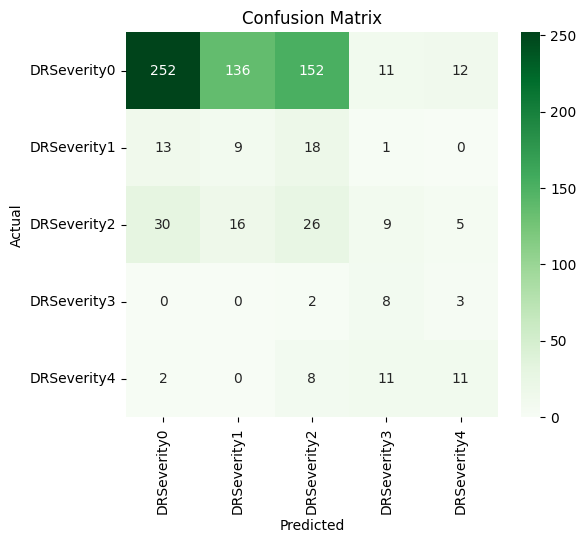

In [11]:
from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


model_path = "/content/drive/MyDrive/DiabeticRetinopathy/savedModels/DRModel1.h5"
model = tf.keras.models.load_model(model_path)


test_dir = "/content/drive/MyDrive/DiabeticRetinopathy/test"

# Define ImageDataGenerator without augmentation (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match the size used in training
    batch_size=32,
    class_mode='categorical',  # or 'binary' if you have 2 classes
    shuffle=False  # Don't shuffle so predictions align with file order
)

# Assuming you have the test_generator from flow_from_directory
class_indices = test_generator.class_indices

# To check class indices (it returns a dictionary)
print("Class Indices:", class_indices)

# # Get the predicted probabilities (using sigmoid for binary classification)
# y_pred_probs = model.predict(test_generator)

# # Map the probabilities to class labels
# y_pred = (y_pred_probs > 0.5).astype(int)  # Get binary predictions (0 or 1)

# # Print the predicted classes with their probabilities
# for i, prob in enumerate(y_pred_probs):
#     print(f"Image {i+1}: Predicted Probability = {prob[0]}, Predicted Class = {list(class_indices.keys())[y_pred[i]]}")



# Get true labels
y_true = test_generator.classes

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", xticklabels=list(class_indices.keys()), yticklabels=list(class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
